In [1]:
%matplotlib inline
from collections import deque
import random

import tensorflow as tf
import gym

import numpy as np
import matplotlib.pyplot as plt

# For rendering
from IPython import display

/home/taeksoon/anaconda3/envs/dl/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Render function

Render results when this notebook runs on a remote server  
(https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server)

In [2]:
def show_state(rgb_arrays):
    for i, rgb_array in enumerate(rgb_arrays):
        plt.figure(3)
        plt.clf()
        plt.imshow(rgb_array)
        plt.title("Step: {}".format(i))
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output(wait=True)

# Discrete Action Space

In [2]:
env = gym.make('CartPole-v0')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 50
learning_rate = 0.001

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Helper Functions

In [3]:
def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def discount_rewards(rewards, gamma):
    cumulative_rewards = np.zeros_like(rewards)
    cumul_r = 0
    for step in reversed(range(len(rewards))):
        cumul_r = cumul_r * gamma + rewards[step]
        cumulative_rewards[step] = cumul_r
    
    return cumulative_rewards

def discount_and_normalize_rewards(rewards, gamma):
    return normalize(discount_rewards(rewards, gamma))

### Deep Q-Learning

In [4]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, n_state), name='input_state')
with tf.name_scope("source") as scope:
    src_hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.relu, name=scope+'hidden')
    src_logit = tf.layers.dense(src_hidden, n_action, name=scope+'logit')
    
    y = tf.placeholder(dtype=tf.float32, shape=(None, n_action), name=scope+'target')

    loss = tf.reduce_mean(tf.square(src_logit - y))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.name_scope("target") as scope:
    tgt_hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.relu, name=scope+'hidden')
    tgt_logit = tf.layers.dense(tgt_hidden, n_action, name=scope+'logit')

src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "source")
tgt_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "target")

update_target_ops = [tf.assign(t_v, s_v) for s_v, t_v in zip(src_vars, tgt_vars)]

In [7]:
n_episode = 10000
n_step = 200
sample_size = 32
init_buf = 10000
buf_size = 50000
target_update_per_step = 10000
epsilon = 0.5
discount_factor = 0.99

init = tf.global_variables_initializer()
rewards = []
with tf.Session() as sess:
    sess.run(init)
    sess.run(update_target_ops)
    
    s_buf = deque([], buf_size)
    a_buf = deque([], buf_size)
    r_buf = deque([], buf_size)
    s__buf = deque([], buf_size)
    done_buf = deque([], buf_size)
    
    global_step = 0
    
    for episode in range(n_episode):    
        s = env.reset()
        
        reward_per_episode = 0

        for step in range(n_step):
            q_vals = sess.run(src_logit, feed_dict={X: [s]})

            a = np.argmax(q_vals[0])
            
            exploration_rate = np.power(epsilon, episode // 100)
            a = np.random.choice([a, 1 - a], 
                                 p=[1-exploration_rate, exploration_rate])

            s_, r, done, _ = env.step(a)
            reward_per_episode += r

            s_buf.append(s)
            a_buf.append(a)
            r_buf.append(r)
            s__buf.append(s_)
            done_buf.append(done)

            s = s_
            global_step += 1
            
            if done:
                break
        
        rewards.append(reward_per_episode)
        
        sample_idx = np.random.choice(len(s_buf), sample_size)
        s_batch = np.array(s_buf)[sample_idx]
        a_batch = np.array(a_buf)[sample_idx]
        r_batch = np.array(r_buf)[sample_idx]
        s__batch = np.array(s__buf)[sample_idx]
        done_batch = np.array(done_buf)[sample_idx]

        q_vals = sess.run(src_logit, feed_dict={X: s_batch})
        q__vals = sess.run(tgt_logit, feed_dict={X: s__batch})
        tgt_vals = r_batch + np.invert(done_batch) * discount_factor * np.max(q__vals, axis=1)

        y_batch = np.copy(q_vals)
        y_batch[np.arange(q_vals.shape[0]), a_batch] = tgt_vals

        # Train source network
        cost, _ = sess.run([loss, train_op], feed_dict={X: s_batch, y: y_batch})

        print("\rEpisode: {} / Cost: {} / Reward: {} / Global step: {}".format(episode, 
                                                                               cost, 
                                                                               reward_per_episode,
                                                                               global_step), 
              end="")

        # Update target network
        if global_step % target_update_per_step == 0:
            sess.run(update_target_ops)

Episode: 9999 / Cost: 0.001463583204895258 / Reward: 157.0 / Global step: 62381927

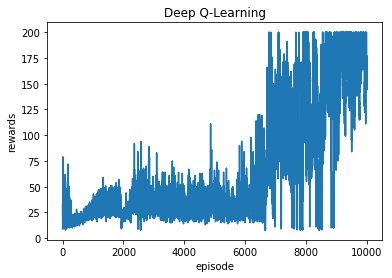

In [8]:
plt.plot(np.arange(n_episode), rewards)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.title("Deep Q-Learning")
plt.show()

### Policy Gradient

In [58]:
tf.reset_default_graph()

X_state = tf.placeholder(dtype=tf.float32, shape=(None, n_state), name="input")

hidden = tf.layers.dense(X_state, 50, activation=tf.nn.relu, name="hidden")
logit = tf.layers.dense(hidden, n_action, activation=tf.nn.softmax, name="logit")

action = tf.placeholder(tf.int32, shape=(None, ), name="action")
labels = tf.one_hot(action, n_action)
action_prob = tf.reduce_sum(tf.multiply(logit, labels), axis=1)

discounted_rewards = tf.placeholder(tf.float32, shape=(None, ), name="discounted_rewards")
cross_entropy = tf.log(action_prob) * discounted_rewards
loss = -tf.reduce_sum(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [60]:
n_episode = 1000
n_step = 200
discount_factor = 0.99

init = tf.global_variables_initializer()
with tf.Session() as sess:
    y_rewards = []
    sess.run(init)
    for episode in range(n_episode):
        obs = env.reset()
        rewards = []
        states = []
        actions = []
        for step in range(n_step):
            policy = sess.run(logit, feed_dict={X_state: [obs]})
            action_val = np.random.choice(np.arange(n_action), p=policy[0])
            actions.append(action_val)
            states.append(obs)

            obs, r, done, _ = env.step(action_val)
            rewards.append(r)
            if done:
                break
        
        # REINFORCE algorithm
        discounted_rewards_val = discount_and_normalize_rewards(rewards, discount_factor)
        
        cost, _ = sess.run([loss, training_op], 
                 feed_dict={
                     X_state: states, 
                     action: actions,
                     discounted_rewards: discounted_rewards_val
                 })

        
        reward_sum = sum(rewards)
        y_rewards.append(reward_sum)
        print("\rEpisode: {} / cost: {} / reward: {}".format(episode, cost, reward_sum), end="")


Episode: 999 / cost: 0.4296846389770508 / reward: 200.00000

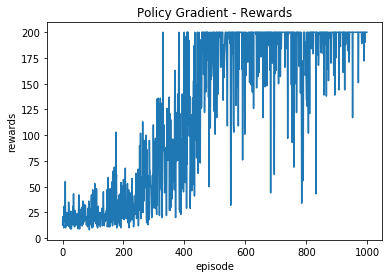

In [76]:
plt.plot(np.arange(n_episode), y_rewards)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.title("Policy Gradient - Rewards")
plt.show()

### Actor - Critic

In [19]:
tf.reset_default_graph()

X_state = tf.placeholder(tf.float32, shape=(None, n_state), name="input")

# Actor
with tf.name_scope("policy_netowrk") as scope:
    policy_hidden = tf.layers.dense(X_state, n_hidden, activation=tf.nn.relu, name="policy_hidden")
    policy_logit = tf.layers.dense(policy_hidden, n_action, activation=tf.nn.softmax, name="policy_logit")
    
    chosen_action = tf.placeholder(tf.int32, shape=(None, ), name="action")
    action_prob = tf.reduce_sum(tf.one_hot(chosen_action, n_action) * policy_logit, axis=1)
    
    advantage = tf.placeholder(tf.float32, shape=(None,), name="advantage")
    cross_entropy = tf.log(action_prob) * advantage
    policy_loss = -tf.reduce_sum(cross_entropy)
    
    policy_training_op = tf.train.AdamOptimizer(learning_rate).minimize(policy_loss)

# Critic
with tf.name_scope("value_network") as scope:
    value_hidden = tf.layers.dense(X_state, n_hidden, activation=tf.nn.relu, name="value_hidden")
    value_logit = tf.layers.dense(value_hidden, 1, name="value_logit")
    
    y_value = tf.placeholder(tf.float32, shape=(None, 1), name="y_value")
    value_loss = tf.reduce_mean(tf.square(y_value - value_logit))
    value_training_op = tf.train.AdamOptimizer(learning_rate).minimize(value_loss)

In [36]:
n_episode = 1000
n_step = 200
discount_factor = 0.99

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # http://rll.berkeley.edu/deeprlcourse/f17docs/lecture_5_actor_critic_pdf.pdf
    # p.17 - Actor-critic algorithms (with discount)
    rewards = []
    for episode in range(n_episode):
        s = env.reset()
        
        reward_per_episode = 0
        
        s_buf = []
        a_buf = []
        r_buf = []
        
        # 1. Sample data(per episode)
        for step in range(n_step):
            p = sess.run(policy_logit, feed_dict={X_state: [s]})
            a = np.random.choice(np.arange(n_action), p=p[0])
            
            s_, r, done, _ = env.step(a)
            
            reward_per_episode += r
            
            s_buf.append(s)
            a_buf.append(a)
            r_buf.append(r)
            
            s = s_
            
            if done:
                break
        
        rewards.append(reward_per_episode)
        s_buf = np.array(s_buf)
        a_buf = np.array(a_buf).reshape(-1, 1)
        r_buf = np.array(r_buf).reshape(-1, 1)
        s__buf = s_buf[1:, :]
        
        # 2. Update critic
        v_s_ = sess.run(value_logit, feed_dict={X_state: s__buf})
        v_s_ = np.concatenate([v_s_, [[0]]])

        y_target_batch = r_buf + discount_factor * v_s_ # bootstrapping

        v_cost, _ = sess.run([value_loss, value_training_op], 
                             feed_dict={X_state: s_buf, y_value: y_target_batch})
        
        # 3. Calculate advantage
        # http://rll.berkeley.edu/deeprlcourse/f17docs/lecture_5_actor_critic_pdf.pdf
        # p.21 - Critics as state-dependent baselines
        
        v_s = sess.run(value_logit, feed_dict={X_state: s_buf})
        
        advantage_batch = discount_rewards(r_buf, discount_factor) - v_s
        
        # 4. Update actor
        policy_cost, _ = sess.run([policy_loss, policy_training_op], 
                                  feed_dict={X_state: s_buf,
                                             chosen_action: a_buf.flatten(),
                                             advantage: advantage_batch.flatten()})
        
        print("\rEpisode: {} / Value cost: {} / Policy cost: {} / Reward: {}".format(episode,
                                                                                     v_cost,
                                                                                     policy_cost,
                                                                                     reward_per_episode),
             end="")

Episode: 999 / Value cost: 9.469500541687012 / Policy cost: 1414.7159423828125 / Reward: 200.000

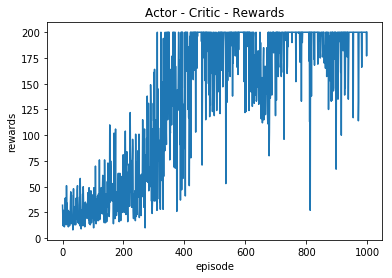

In [37]:
plt.plot(np.arange(n_episode), rewards)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.title("Actor - Critic - Rewards")
plt.show()

# Continuous Action Space

In [3]:
env = gym.make('Pendulum-v0')

s_space = env.observation_space
print("State: shape={}, low={}, high={}".format(s_space.shape, s_space.low, s_space.high))
a_space = env.action_space
print("Action: shape={}, low={}, high={}".format(a_space.shape, a_space.low, a_space.high))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State: shape=(3,), low=[-1. -1. -8.], high=[1. 1. 8.]
Action: shape=(1,), low=[-2.], high=[2.]


### Random Agent

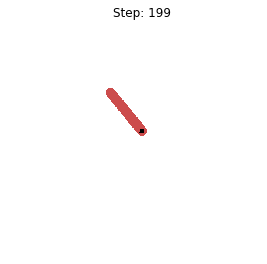

In [4]:
s = env.reset()

done = False

step = 0
rgb_arrays = []
while not done and step < 200:
    s, r, done, _ = env.step(env.action_space.sample())
    print("\rReward: {:.5f}, Step: {:0>3d}".format(r, step), end="")
    step += 1
    rgb_arrays.append(env.render(mode='rgb_array'))

env.close()
show_state(rgb_arrays)

### Deep Deterministic Policy Gradient (DDPG)

In [4]:
def actor(state, action_size, action_bound, name=""):
    """
    state: tensor
    action_size: int
    """
    with tf.variable_scope(name):
        h1 = tf.layers.dense(state, 400)
        h1 = tf.contrib.layers.layer_norm(h1, activation_fn=tf.nn.relu)
        
        h2 = tf.layers.dense(h1, 300, activation=None)
        h2 = tf.contrib.layers.layer_norm(h2, activation_fn=tf.nn.relu)
        
        initializer = tf.random_uniform_initializer(-0.003, 0.003)
        o = tf.layers.dense(h2, action_size, activation=tf.tanh, kernel_initializer=initializer)
        multiplier = tf.constant(np.abs(np.max(action_bound)), dtype=tf.float32)
        o = tf.clip_by_value(o * multiplier, action_bound[0], action_bound[1])
        
        return o

In [5]:
def critic(state, action, name=""):
    """
    state: tensor
    action: tensor
    """
    with tf.variable_scope(name):
        h1 = tf.layers.dense(state, 400, activation=None)
        h1 = tf.contrib.layers.layer_norm(h1, activation_fn=tf.nn.relu)
        
        h2 = tf.concat([h1, action], axis=-1)
        h2 = tf.layers.dense(h2, 300, activation=tf.nn.relu)
        
        initializer = tf.random_uniform_initializer(-0.003, 0.003)
        o  = tf.layers.dense(h2, 1, kernel_initializer=initializer)
        
        return o

In [6]:
def update_vars(src_scope_name, tgt_scope_name, tau):
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, src_scope_name)
    tgt_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, tgt_scope_name)
    
    update_ops = [tf.assign(t_v, (1 - tau) * t_v + tau * s_v) for s_v, t_v in zip(src_vars, tgt_vars)]
    
    return tf.group(*update_ops)

In [11]:
buf_size = 100000
n_episode = 300
n_step = 200
batch_size = 64
actor_learning_rate = 0.0001
critic_learning_rate = 0.001
tau = 0.001
discount_rate = 0.99

In [12]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, s_space.shape[0]), name="X")
action = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="action")
action_bound = (a_space.low[0], a_space.high[0])

# Critic Netowrk
critic_logit = critic(X, action, "critic")
critic_y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="critic_y")
critic_loss = tf.reduce_mean(tf.pow(critic_y - critic_logit, 2))
critic_training_op = tf.train.AdamOptimizer(critic_learning_rate).minimize(critic_loss)

# Actor Network
actor_logit = actor(X, a_space.shape[0], action_bound, "actor")

critic_action_grad = tf.gradients(critic_logit, action)[0]
actor_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "actor")
# By setting 'grad_ys', each gradient is multiplied by 'critic_grad'
# Refer to: https://stackoverflow.com/questions/42399401/use-of-grads-ys-parameter-in-tf-gradients-tensorflow
# By multiplying -1, we are trying to maximize return from the objective function.
actor_grads = tf.gradients(actor_logit, actor_vars, grad_ys=(-1)*critic_action_grad)
actor_grads = [g / batch_size for g in actor_grads]
actor_training_op = tf.train.AdamOptimizer(actor_learning_rate).apply_gradients(zip(actor_grads, actor_vars))

actor_target_logit = actor(X, a_space.shape[0], action_bound, name="actor_target")
critic_target_logit = critic(X, action, name="critic_target")

init_actor_target = update_vars("actor", "actor_target", 1)
init_critic_target = update_vars("critic", "critic_target", 1)

actor_target_update_op = update_vars("actor", "actor_target", tau)
critic_target_update_op = update_vars("critic", "critic_target", tau)

In [13]:
# Referenced from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

Episode: 299 / Critic Losses: 3.809056282043457 / Rewards: -129.307086369489448

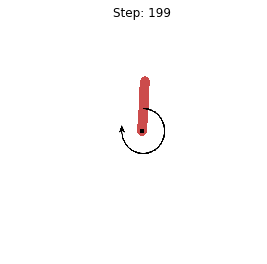

In [14]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run([init_actor_target, init_critic_target])
    
    replay_buf = deque(maxlen=buf_size)
    rewards = []
    noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros_like(a_space.shape))
    for episode in range(n_episode):
        s = env.reset()
        noise.reset()
        
        r_per_ep = 0
        critic_losses = []
        rgb_arrays = []
        for step in range(n_step):
            a = sess.run(actor_logit, feed_dict={X: [s]})[0]
            a = a + noise()
            
            s_, r, done, _ = env.step(a)
            r_per_ep += r
            if episode and episode % 50 == 0:
                rgb_arrays.append(env.render(mode='rgb_array'))
            
            replay_buf.append((s, a, r, s_))
            s = s_
            
            # The first episode is for buffer population.
            if len(replay_buf) > batch_size:
                batch = random.sample(replay_buf, batch_size)
                
                s_batch = np.array([i[0] for i in batch])
                a_batch = np.array([i[1] for i in batch])
                r_batch = np.array([i[2] for i in batch]).reshape(-1, 1)
                s__batch = np.array([i[3] for i in batch])
                
                a_ = sess.run(actor_target_logit, feed_dict={X: s__batch})
                q_ = sess.run(critic_target_logit, feed_dict={X: s__batch, action: a_})
                
                q_y = r_batch + discount_rate * q_
                
                critic_loss_val, _ = sess.run([critic_loss, critic_training_op], 
                                              feed_dict={X: s_batch, 
                                                         action: a_batch, 
                                                         critic_y: q_y})
                critic_losses.append(critic_loss_val)
                
                cur_a_batch = sess.run(actor_logit, feed_dict={X: s_batch})
                sess.run(actor_training_op, feed_dict={X: s_batch, action: cur_a_batch})
                sess.run([actor_target_update_op, critic_target_update_op])
            
            if done:
                break
        
        print("\rEpisode: {} / Critic Losses: {} / Rewards: {}".format(
            episode, np.mean(critic_losses), r_per_ep), end="")
        rewards.append(r_per_ep)
        
        if episode and episode % 50 == 0:
            show_state(rgb_arrays)

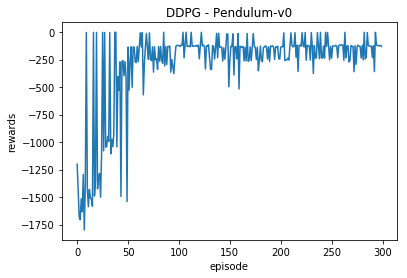

In [16]:
plt.plot(np.arange(len(rewards)), rewards)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.title("DDPG - Pendulum-v0")
plt.show()